In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3" # set gpu number to use

from comet_ml import Experiment

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
import torch.functional as F

import torchvision
from torchvision import transforms

from tqdm import tqdm_notebook

device = 'cuda' # or 'cpu'

#### Атеншон (!)

Если вы учите не на гпу, перейдите от CIFAR-100 на CIFAR-10

В этой тетрадке вам предлагается обучить простую нейронную сверточную сеть на датасете CIFAR-100

In [2]:
# Заранее собранные датасеты

data_path = './cifar100-data'

train_set = torchvision.datasets.CIFAR100(root=data_path,
                                          train=True,
                                          download=True,
                                          transform=transforms.ToTensor())
test_set = torchvision.datasets.CIFAR100(root=data_path,
                                         train=False,
                                         download=True, 
                                         transform=transforms.ToTensor())


Files already downloaded and verified
Files already downloaded and verified


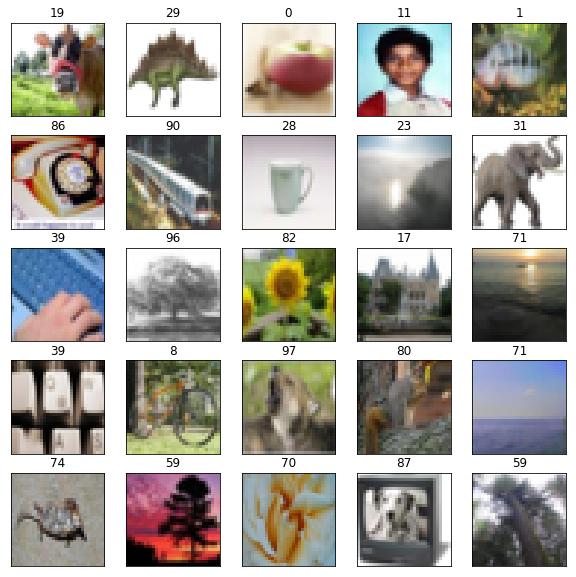

In [3]:
# CIFAR 100, 32x32 картинки

plt.figure(figsize=(10, 10))
for index, (image, label) in enumerate(train_set):
    if index >= 25:
        break
    plt.subplot(5, 5, index + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.yticks([])
    plt.xticks([])
    plt.title(str(label))
plt.show()

In [4]:
# Соберем все датасеты в даталоадере, соберем батчи 

BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

In [5]:
batch = next(iter(train_loader))
# Первый элемент батча - тензор с картинками
print(batch[0].shape)
# Второй - тензор с правильными лейблами
print(batch[1].shape)

torch.Size([32, 3, 32, 32])
torch.Size([32])


In [6]:
class CifarModel(nn.Module):
    def __init__(self, ):
        super(CifarModel, self).__init__()
        self.emb = nn.Sequential(
            nn.Conv2d(3, 32, 5, padding=2), # 32x32x32
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.02),
            nn.Conv2d(32, 64, 5, stride=2, padding=2),  # 64x16x16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.02),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 128x8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.02),
            nn.Conv2d(128, 32, 3, stride=2, padding=1),  # 128x4x4
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(32),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(32*4*4, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512, 100),
        )
        
    def forward(self, x):
        return self.fc(self.emb(x).view(x.shape[0], -1))
        

In [7]:
model = CifarModel().to(device)

Теперь здесь определите какой лосс и какой оптимизатор вы будете использовать

In [8]:
from sklearn.metrics import accuracy_score

criterion = nn.CrossEntropyLoss()
optimizator = torch.optim.Adam(model.parameters())


Здесь напишите свой цикл обучения, обучайте модель как минимум 10 эпох, логируйте качество модели на трейне и на тесте.

Подумайте про то, чтобы перестать использовать обычные питоновские графики для логирования.

Один из хороших вариантов - comet.ml, штука позволяет сохранять все метрики/лоссы и отрисовывать их в веб-тулзе


In [9]:
experiment = Experiment(api_key="HIZapbzNjFips0c32Co7gXkQZ",
                        project_name="hse-gans",
                        workspace="maximartemev")

for epoch in tqdm_notebook(range(15), desc='Epoch loop'):
    with experiment.train():
        model.train()
        for ind, (image, label) in tqdm_notebook(enumerate(train_loader), desc='train loop', leave=False):
            pred = model(image.to(device))
            loss = criterion(pred, label.to(device))
            loss.backward()
            optimizator.step()
            optimizator.zero_grad()
            experiment.log_metric("loss", loss.item())
            experiment.log_metric("accuracy", accuracy_score(label.data.numpy(),
                                                             torch.argmax(pred.cpu(), dim=1).data.numpy())
                                 )
    with experiment.test():
        model.eval()
        accs = []
        for ind, (image, label) in enumerate(train_loader):
            pred = model(image.to(device))
            accs.append(accuracy_score(label.data.numpy(),
                                       torch.argmax(pred.cpu(), dim=1).data.numpy()))
        experiment.log_metric("accuracy", np.mean(accs), epoch=epoch)
        

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/maximartemev/hse-gans/a005750bf3e34fd78fd5059dea649887



KeyboardInterrupt: 

### Задание: 

1. Получить accuracy не меньше 0.7

In [11]:
model.eval()
preds, labels = [], []
for ind, (image, label) in enumerate(train_loader):
    pred = model(image.to(device))
    preds.extend(torch.argmax(pred.cpu(), dim=1).data.tolist())
    labels.extend(label.data.tolist())
print(accuracy_score(labels, preds))

0.8084
